In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import datetime as dt
import random
import pickle
import math
import csv
import os

%matplotlib inline

### Visualizations & plots

In [2]:
home_dir = os.path.expanduser("~")
code_dir = os.path.join(home_dir,"Developer","GitHub","endogenous-growth")
nets_dir = os.path.join(code_dir,"networks")
figs_dir = os.path.join(code_dir,"tmp")

In [3]:
from src.models import InOneOutOne, InOneOutTwo, InTwoOutOne, InOutThree, InTwoOutTwo

### Node dynamics -- node trajectories

In [4]:
# DEFINE NETWORKS
runs = list(range(50))
gammas = [0,1,2,3,4,5,6,7,8,9,"inf"]

m = 3
alpha = 0.95
N = 100

i_s = [3,10,20,30,40,50,60,70,80,90] # nodes entering at step i

# NORMALIZED RANK OF NODES i
ranks = {}
ranks_avg = {}
scores = {}
scores_avg = {}

for gamma in gammas:

    # STORE OUTPUT
    ranks[gamma] = {}
    ranks_avg[gamma] = {} 
    scores[gamma] = {}
    scores_avg[gamma] = {}

    for i in i_s:

        # STORE OUTPUT
        ranks[gamma][i] = [] 
        scores[gamma][i] = [] 
        
        for run in runs:
            # DEFINE NETWORK
            network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

            # LOAD RUN
            if not os.path.exists(os.path.join(code_dir,"networks",network,"run_"+str(run)+'.pkl')):
                continue
            with open(os.path.join(code_dir,"networks",network,"run_"+str(run)+'.pkl'), 'rb') as f:
                model = pickle.load(f)

            # UNPACK
            networks = model.networks
            
            # IDENTIFY NODE i
            n_i = max(networks[i-1].nodes())

            # GET SCORES
            score = [G.nodes[n_i]['score'] for G in networks[i-1:]]
            scores[gamma][i].append(np.array(score))

            # GET RANKS
            valuess = [nx.get_node_attributes(G, 'score') for G in networks[i-1:]]
            rankings = [{node: rank for rank, node in enumerate(sorted(values, key=values.get))} for values in valuess]
            rank = [ranking[n_i]/(i+j-1) for j, ranking in enumerate(rankings)]
            ranks[gamma][i].append(np.array(rank))
                
        # GET AVERAGE RANKS
        ranks_avg[gamma][i] = np.zeros(len(ranks[gamma][i][0]))
        n_runs = 0
        for run in runs:
            try:
                ranks_avg[gamma][i] = ranks_avg[gamma][i] + ranks[gamma][i][run]
            except:
                break
            n_runs += 1
        ranks_avg[gamma][i] = ranks_avg[gamma][i]/n_runs

        # GET AVERAGE SCORES
        scores_avg[gamma][i] = np.zeros(len(scores[gamma][i][0]))
        n_runs = 0
        for run in runs:
            try:
                scores_avg[gamma][i] = scores_avg[gamma][i] + scores[gamma][i][run]
            except:
                break
            n_runs += 1
        scores_avg[gamma][i] = scores_avg[gamma][i]/n_runs

    # READY OUTPUT DIRECTORY
    output = "_".join(["i1o1","m"+str(m),"a"+str(alpha)])
    if not os.path.exists(os.path.join(figs_dir,output)):
        os.mkdir(os.path.join(figs_dir,output))

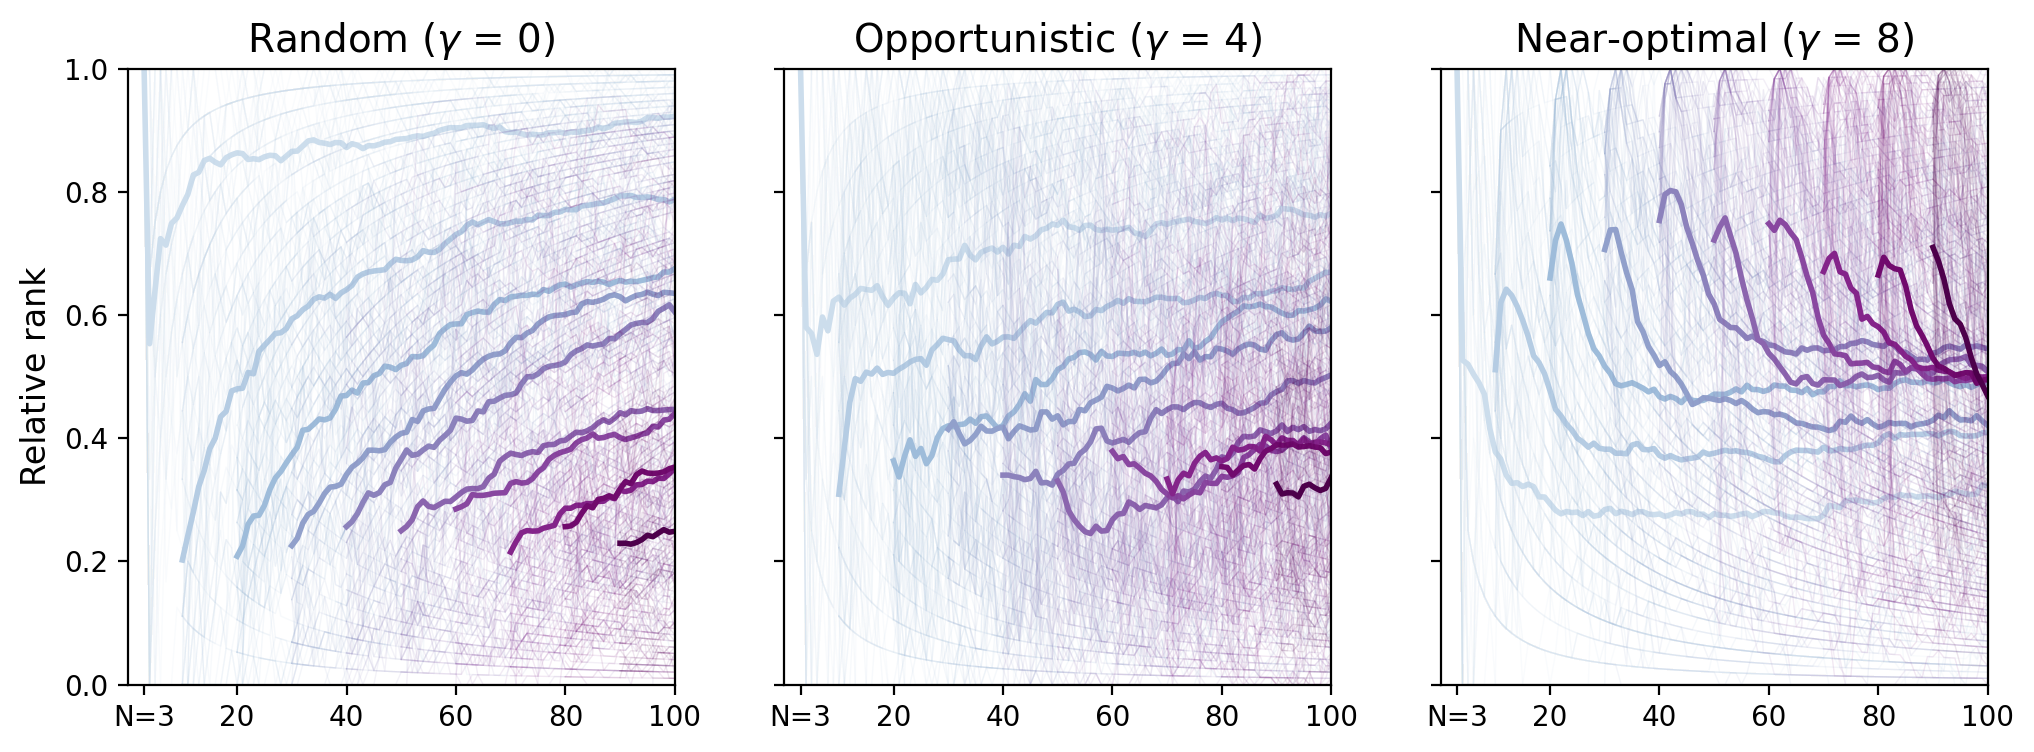

In [5]:
# GAMMAS
plot_gammas = [0,4,8]
N=100

# Create a colorbar
cmap = plt.colormaps['BuPu'] 
colors = [cmap(i) for i in np.linspace(0.2, 1, len(i_s))]

#initialize figure
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12,4), sharex=True, sharey=True)

for c, i in enumerate(i_s):

       x = range(i,N+1)

       # Plot the instances
       for run in runs:
              ax[0].plot(x, ranks[plot_gammas[0]][i][run], linestyle='-', linewidth = 0.5, alpha=0.1, color=colors[c])
              ax[1].plot(x, ranks[plot_gammas[1]][i][run], linestyle='-', linewidth = 0.5, alpha=0.1, color=colors[c])
              ax[2].plot(x, ranks[plot_gammas[2]][i][run], linestyle='-', linewidth = 0.5, alpha=0.1, color=colors[c])

       # Plot the averages
       ax[0].plot(x, ranks_avg[plot_gammas[0]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])
       ax[1].plot(x, ranks_avg[plot_gammas[1]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])
       ax[2].plot(x, ranks_avg[plot_gammas[2]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])

ax[0].set_xticks([3]+list(range(20,N+1,20)))
ax[0].set_xticklabels(['N=3', '20', '40', '60', '80', '100'])
# Remove the first tick mark
#for i in range(3):
#       lines = ax[i].get_xticklines()
#       lines[0].set_visible(False)

ax[0].set_xlim(0,N)
ax[0].set_ylim(0,1)

ax[0].set_title("Random ("+r'$\gamma$'+f' = {plot_gammas[0]})', fontsize=14)
ax[1].set_title("Opportunistic ("+r'$\gamma$'+f' = {plot_gammas[1]})', fontsize=14)
ax[2].set_title("Near-optimal ("+r'$\gamma$'+f' = {plot_gammas[2]})', fontsize=14)
ax[0].set_ylabel("Relative rank", fontsize=12)

plt.savefig(os.path.join(figs_dir,output,"node-dynamics.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"node-dynamics.pdf"), bbox_inches='tight')
plt.show()
plt.close()

In [6]:
# Last 10 steps
dfs = []
for gamma in gammas:
    for i in i_s:
        df = pd.DataFrame(np.mean(np.array(ranks[gamma][i])[:,-10:],axis=1), columns=['rank_avg'])
        df['rank_std'] = pd.DataFrame(np.std(np.array(ranks[gamma][i])[:,-10:],axis=1), columns=['rank_std'])['rank_std']
        df['diff_avg'] = pd.DataFrame(np.mean(np.diff(ranks[gamma][i])[:,-10:],axis=1), columns=['diff_avg'])['diff_avg']
        df['diff_abs_avg'] = pd.DataFrame(np.mean(np.abs(np.diff(ranks[gamma][i])[:,-10:]),axis=1), columns=['diff_abs_avg'])['diff_abs_avg']
        df['diff_std'] = pd.DataFrame(np.std(np.diff(ranks[gamma][i])[:,-10:],axis=1), columns=['diff_std'])['diff_std']
        df['gamma'] = gamma
        df['i'] = i
        dfs.append(df)
df_ranks = pd.concat(dfs, ignore_index=True)

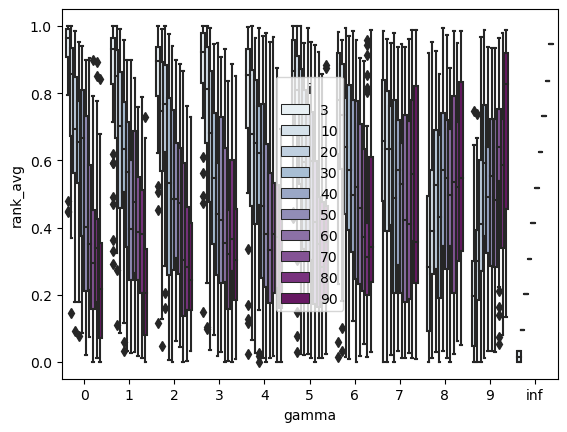

In [7]:
# Last 10 steps
sns.boxplot(data=df_ranks,
            x='gamma',
            y='rank_avg',
            hue='i',
            palette='BuPu')
plt.show()

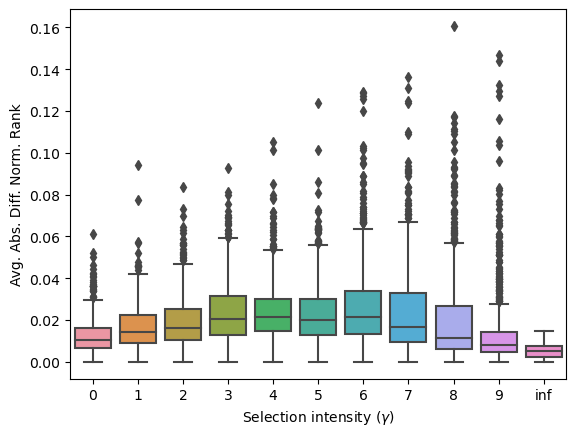

In [8]:
# Last 10 steps
sns.boxplot(data=df_ranks,
            x='gamma',
            y='diff_abs_avg')
plt.xlabel(r"Selection intensity ($\gamma$)")
plt.ylabel("Avg. Abs. Diff. Norm. Rank")
plt.savefig(os.path.join(figs_dir,output,"node-dynamics_diffs.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"node-dynamics_diffs.pdf"), bbox_inches='tight')
plt.show()

### Node attractiveness

In [9]:
# DEFINE NETWORKS
runs = list(range(50))
gammas = [0,1,2,3,4,5,6,7,8,9,"inf"]

m = 3
alpha = 0.95
N = 100

# AGE OF NODES SELECTED AT STEP i
out_ages = {}
in_ages = {}

for gamma in gammas:

    # STORE OUTPUT
    out_ages[gamma] = defaultdict(list)
    in_ages[gamma] = defaultdict(list)
        
    for run in runs:
        # DEFINE NETWORK
        network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

        # LOAD RUN
        if not os.path.exists(os.path.join(code_dir,"networks",network,"run_"+str(run)+'.pkl')):
            continue
        with open(os.path.join(code_dir,"networks",network,"run_"+str(run)+'.pkl'), 'rb') as f:
            model = pickle.load(f)

        # UNPACK
        networks = model.networks

        # AGE MAPPING
        n_is = sorted(list(networks[-1].nodes(data=False)))
        age = {n_i:(idx+1) for idx, n_i in enumerate(n_is)}

        # GET NETWORKS
        for G in networks[3:]:
            
            # IDENTIFY NODE i
            n_i = max(G.nodes())
            # GET IN AND OUT-LINKS
            in_link_node = list(G.predecessors(n_i))[0]
            out_link_node = list(G.successors(n_i))[0]

            # RECORD AGES
            in_ages[gamma][age[n_i]].append(age[in_link_node])
            out_ages[gamma][age[n_i]].append(age[out_link_node])

    # READY OUTPUT DIRECTORY
    output = "_".join(["i1o1","m"+str(m),"a"+str(alpha)])
    if not os.path.exists(os.path.join(figs_dir,output)):
        os.mkdir(os.path.join(figs_dir,output))

In [10]:
# Get this into plottable format
dfs = []
for gamma in gammas:
    df = pd.DataFrame(in_ages[gamma])
    df['gamma'] = gamma
    df['gamma_num'] = gamma if gamma != "inf" else 10
    df['in_out'] = "in"
    dfs.append(df)
    df = pd.DataFrame(out_ages[gamma])
    df['gamma'] = gamma
    df['gamma_num'] = gamma if gamma != "inf" else 10
    df['in_out'] = "out"
    dfs.append(df)
df_attr = pd.concat(dfs)
df_attr = pd.melt(df_attr, id_vars=['gamma', 'gamma_num', 'in_out'], value_vars=[i for i in range(4,101)], var_name='step', value_name='age')
df_attr['age_norm'] = df_attr['age'] / (df_attr['step']-1)

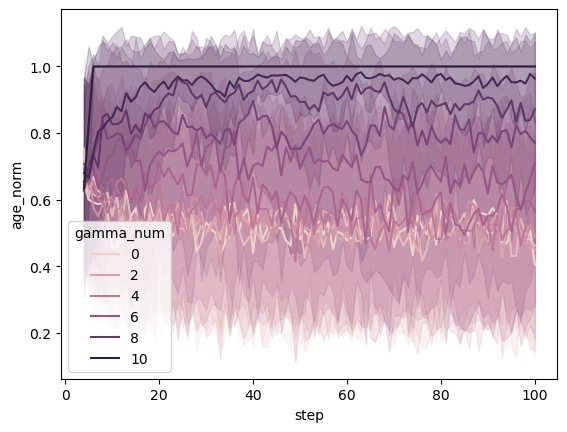

In [11]:
sns.lineplot(data=df_attr[df_attr['in_out'] == "out"], 
             x='step', 
             y='age_norm', 
             hue='gamma_num', 
             errorbar='sd')  # ci='sd' shows standard deviation
plt.show()

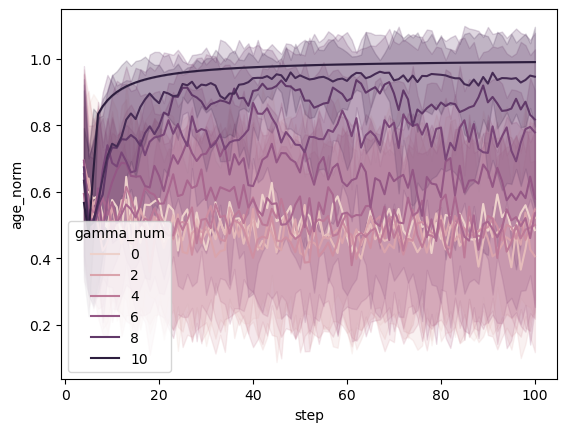

In [12]:
sns.lineplot(data=df_attr[df_attr['in_out'] == "in"], 
             x='step', 
             y='age_norm', 
             hue='gamma_num', 
             errorbar='sd')  # ci='sd' shows standard deviation
plt.show()

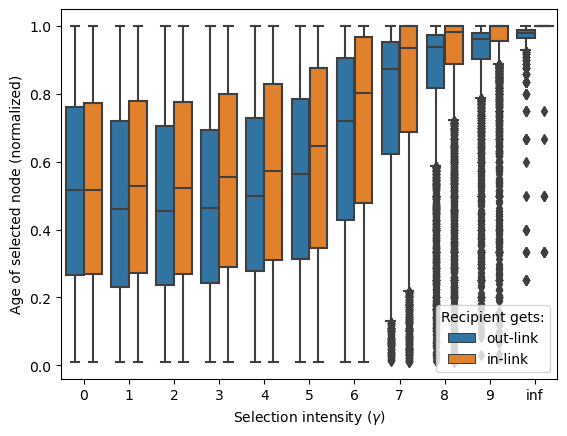

In [13]:
# Doesn't need filtering, the initial noise are outliers
df_attr['recipient_gets'] = df_attr['in_out'].apply(lambda x: "out-link" if x == 'in' else "in-link")
sns.boxplot(data=df_attr,
            x='gamma',
            y='age_norm',
            hue='recipient_gets')
plt.xlabel(r"Selection intensity ($\gamma$)")
plt.ylabel(r"Age of selected node (normalized)")
plt.legend(title='Recipient gets:', loc='lower right')
plt.savefig(os.path.join(figs_dir,output,"node-dynamics_attr.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"node-dynamics_attr.pdf"), bbox_inches='tight')
plt.show()